# 4.2 Multivariate Linear Regression

Welcome to the practical section of module 4.2. Here we'll continue with the advertising-sales dataset to investigate the ideas of multivariate linear regression. As before, we'll begin by importing the necessary libraries for our work.

In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm  # this is for colormaps for 2D surfaces
from mpl_toolkits.mplot3d import Axes3D  # this is for 3D plots
plt.rcParams['figure.figsize'] = (10, 10)

Before We start working on multivariate linear regression, we need to say a few words about the **scale_features** function we treated as black-box in the previous module. Remember?

In [15]:
def scale_features(X, scalar=None):
    if(len(X.shape) == 1):
        X = X.reshape(-1, 1)
    
    if scalar == None:
        scalar = StandardScaler()
        scalar.fit(X)
    
    return scalar.transform(X), scalar

In the videos we learned the importance of **feature scaling** in boosting the learning speed. This is particulary useful when we have small datasets (like the one we're working with). So how does the **scale_features** function work?

The function takes two arguments: the features *X* and an optinal **StandardScalar** object *scalar*. The function begins by checking the shape of the features and makes sure that it's not in the form (n,) where the second number is missing (sklearn doesn't work with data with that shape), then the function has two working modes:

1. **When *scalar* is not provided**: In this case, a new **StandardScalar** is created and fitted on the features matrix. Fitting here means to calculate the mean $\mu$ and the standard deviation $\sigma$ for the features X. After that the features are transformed (aka scaled) and returned along with the fitted scalar.

2. **When a fitted *scalar* is provided**: In this case the function jumps directly to scaling the features.

The transformation of the features is done through this equation:

$$x_i' = \frac{x_i - \mu}{\sigma}$$

The benfit of this approach is that we can scale a some part of the data with a scalar that was previously fit on another part of the data, why is this important?

Remember in the last module when we partitoned the data into two parts: a training part and a test part. The test part needs to be completely unseen by our model during training and it also needs to be scaled by the same way the training data are. If we fit the scalar on all the data (including the test set), values of the test set data will sneak its way into the $\mu$ and $\sigma$ of the scalar, hence into the scaled values of the training set and eventually into the model itself, the model then would **see** the test data and that is not good.

The solution is to use the function without any *scalar* provided on the training data and get the fitted scalar, we then use that fitted scalar to scale the test set. Now we can have a test set that is scaled in the same way as the training set while remaining unseen to the model.

Now, that we've finished on the practical aspects of feature scaling, we need to retrieve our dataset and start working.

In [3]:
# get the advertising data set

dataset = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv')
dataset = dataset[["TV", "Radio", "Newspaper", "Sales"]]  # filtering the Unamed index column out of the dataset

# here we the first 10 samples of the dataset
dataset[:10]

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
5,8.7,48.9,75.0,7.2
6,57.5,32.8,23.5,11.8
7,120.2,19.6,11.6,13.2
8,8.6,2.1,1.0,4.8
9,199.8,2.6,21.2,10.6


This time, as we're doing multivariate linear regression, we'll be working on both **TV** and **Newspaper** variables. As we did before, we'll start off by visualizing our data, but because our data now is in three dimensions (TV, Newspaper, Sales) we'll be using **metaplotlib** directly as **panads** doesn't do 3D plots (unfortunately!).

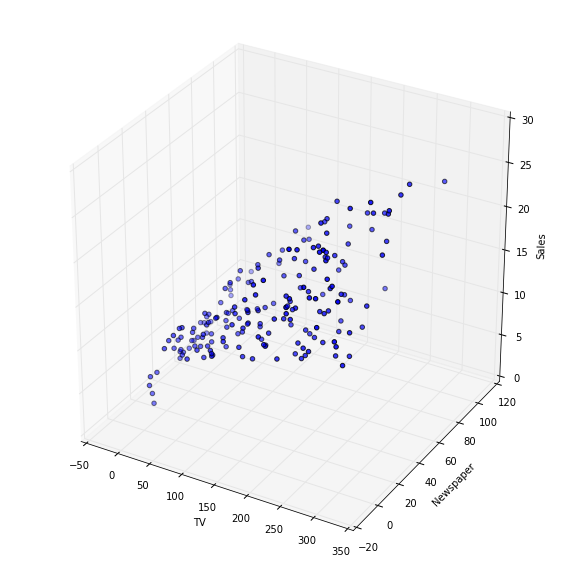

In [6]:
plot3D = plt.figure()  # here we create a metaplotlib figure, an empty plot if you like
plot3D = plot3D.gca(projection='3d')  # here we specify that we'll be creating a 3D plot

# here we create our scatter plot given our data
plot3D.scatter(dataset["TV"], dataset["Newspaper"], dataset["Sales"])

# now we'll put some labels on the axes
plot3D.set_xlabel("TV")
plot3D.set_ylabel("Newspaper")
plot3D.set_zlabel("Sales")

# finally we show our plot
plt.show()

Next we prepare our dataset for the model training just as we did last time.

In [18]:
dataset_size = len(dataset)
training_size = np.floor(dataset_size * 0.8).astype(int)

# First we split the shuffled dataset into two  parts: training and test
X_training = dataset[["TV", "Newspaper"]][:training_size]
y_training = dataset["Sales"][:training_size]

X_test = dataset[["TV", "Newspaper"]][training_size:]
y_test = dataset["Sales"][training_size:]

# Second we apply feature scaling on X_training and X_test
X_training, training_scalar = scale_features(X_training)
X_test,_ = scale_features(X_test, scalar=training_scalar)

Notice this time that our X_training and X_test has two columns: one for each feature, so our regression model will be in the form:
$$y = w_0 + w_1x_1 + w_2x_2$$

Where $x_1$ corresponds to the **TV** features and $x_2$ corresponds to the **Newspaper** fatures. We can now train our linear regression model in the exact same way we did before.

In [21]:
model = SGDRegressor(loss='squared_loss')
model.fit(X_training, y_training)

w0 = model.intercept_
w1 = model.coef_[0]  # Notice that model.coef_ is a list now not a single number
w2 = model.coef_[1]

print "Trained model: y = %0.2f + %0.2fx₁ + %0.2fx₂" % (w0, w1, w2)

Trained model: y = 12.16 + 3.59x₁ + 0.89x₂


Now, we evaluate our model against the test data using MSE.

In [23]:
MSE = np.mean((y_test - model.predict(X_test)) ** 2)

print "The Test Data MSE is: %0.3f" % (MSE)

The Test Data MSE is: 13.338


We can also visualize our regression model by plotting the regression ***plane*** alongside the scatter lot of our data points.

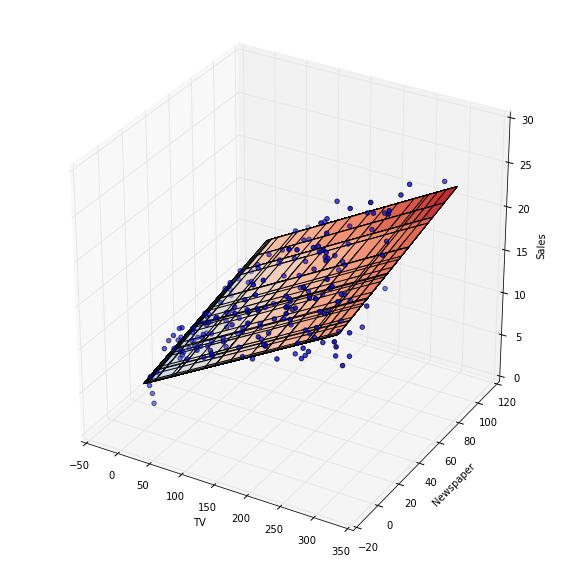

In [43]:
plot3D = plt.figure()
plot3D = plot3D.gca(projection='3d')


plot3D.scatter(dataset["TV"], dataset["Newspaper"], dataset["Sales"])

# here we get the coordinate matricies for the surface
X_plane, Y_plane = np.meshgrid(dataset["TV"], dataset["Newspaper"])

# here we get the scaled version of the coordinate matrices
scaled_dataset,_ = scale_features(dataset[["TV", "Newspaper"]], scalar=training_scalar)
X_plane_scaled, Y_plane_scaled = np.meshgrid(scaled_dataset[:,0], scaled_dataset[:,1])

# here we get the Z values for the surface using the model
Z_plane = w0 + w1 * X_plane_scaled + w2 * Y_plane_scaled

plot3D.plot_surface(X_plane,Y_plane, Z_plane, rstride=1, cstride=1, cmap=cm.coolwarm)

# now we'll put some labels on the axes
plot3D.set_xlabel("TV")
plot3D.set_ylabel("Newspaper")
plot3D.set_zlabel("Sales")

# finally we show our plot
plt.show()

An interesting observation can be made from the values of the trained weights. There's much more weight put on **TV** ads ($x_1$) than put on the the **Newspaper** ones. In other words: Tv adds contribute much more to the sales than newspaper. A piece of information like this would possibly lead to a change in the marketing plan to swap funds from the newspaper ads and push it into the tv ads!


Before concluding this module. Let's say a few words about the learning rate. From the videos we knew that the larning rate represents how much we're gonna go into the direction of the gardient, and this was expressd through the following formula:

$$W_j := W_j - \alpha\frac{\partial}{\partial W_j}J(W)$$

We also learned that this alpha is subject to tuning that if it was too large, our steps would overshoot and we'd miss the minimum. On theother hand if it was too small it'd take a very long time in training. We'd like to see how we can tune this parameter for our example here.

In scikit-learn, alpha can be adjusted using the argument *eta0* in **SGDRegressor** constructor. You may notice that it has a *0* in the end of its name; that's because scikit-learn uses this as the intial value for a learning rate that decrases with time. This behavior can be turned off by passing *learning_rate='constant'* to the model constructor (or can be set to different behavior, check the [SGDRegressor documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) for more info), but we won't be doing that.

By default, *eta0* is set to 0.01 and this is the value we have been using all along. Seeing that our dataset is small, we'd like to make the learning a litlle bit faster without overshooting around the minimum. We can increase *eta0* a little bit to 0.05 and hope that it gets a better model (A better model will have less MSE on the test data)

In [109]:
model = SGDRegressor(loss='squared_loss', eta0=0.05)
model.fit(X_training, y_training)

w0 = model.intercept_
w1 = model.coef_[0]  # Notice that model.coef_ is a list now not a single number
w2 = model.coef_[1]

print "Trained model: y = %0.2f + %0.2fx₁ + %0.2fx₂" % (w0, w1, w2)

Trained model: y = 14.03 + 4.12x₁ + 1.09x₂


In [110]:
MSE = np.mean((y_test - model.predict(X_test)) ** 2)

print "The Test Data MSE is: %0.3f" % (MSE)

The Test Data MSE is: 12.981


You're encourged to play around with the learning rate and explore what happens to the model accordingly.

## Exercise 1
Build a mutivariate regression model for the **Sales** using both **Radio** and **Newspaper**.

## Exercise 2
Build a multivariate linear regression model for the **Sales** given all the three media values.